In [1]:
# Common stuff reused by all applications
from analysis_common import *
%matplotlib inline


EXPERIMENT_SIZE_FIELDS = [
    "number_of_fragments",
    "points_per_fragment", 
]

PLATFORM_FIELDS = [
    "nodes",
    "cpus_per_node",
    "backends_per_node",
    "dataclay",
    "use_split",
]

HANDPICKED_OUTLIERS = [
    # A lot of those seem to be for the executions done during 15th june at 7am. 
    # 6am executions were still fine.
    # Temperature issues? General jitter? Sysadmin updating the system?
    # We may never know
    23429588, 23424157, 23424125, 23505880, 23505871, 23505863, 23429586, 23505895, 23505868,
    23505904, 23505912, 23505886, 23505860,
    23505887, 23505892, 23505915, 23505913, 23505864,
    23503326, 23503411, 23429587, 23505920, 23505865,
    23429586, 23414331, 23414325,
    23424174, 23424176,
    23429575,
    23505894,
    23756636, 23503291, 23503143, 23424197, 23424199,
]

In [2]:
db = DataStorage("kmeans-split")
df = prepare_df(db, HANDPICKED_OUTLIERS)

df.query("start_ts > '2022-06-09'", inplace=True)

In [3]:
edf = df.explode("iteration_time").sort_values('mode')
edf['iteration_time'] = edf['iteration_time'].astype(float)
winsorize_edf(edf, "iteration_time", ["mode", "nodes","points_per_fragment", "number_of_fragments"])

/home/alex/BSC/split-miniapps/analysis/analysis_common.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df[mask] = mstats.winsorize(working_df[mask], limits=[0, 0.1])


# Weak scaling (small blocks)

- 2304 fragments **per node**
- 128000 points per fragment

This shows the behaviour of split in a typical scalability environment. The quantity of objects is high and increases with the number of nodes. The benefits of the split should be more apparent as the number of nodes / work increases.

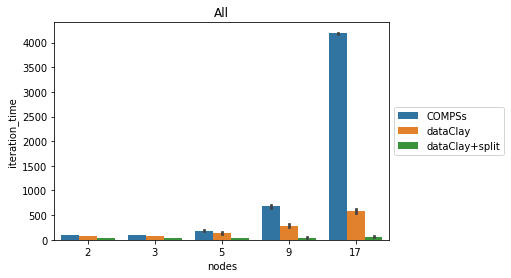

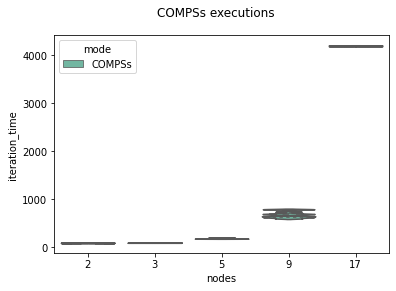

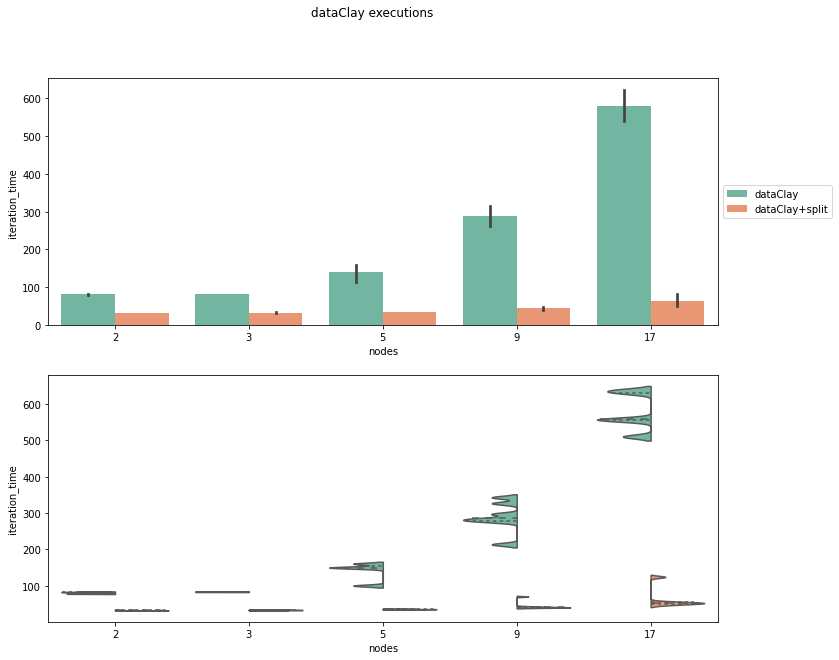

initialization_time  iteration_time
nodes mode                                               
2     COMPSs                    22.169395       91.058590
      dataClay                  59.893290       81.382013
      dataClay+split            60.259005       32.510683
3     COMPSs                    23.130964       94.088200
      dataClay                  85.375222       83.600312
      dataClay+split            75.331375       33.667751
5     COMPSs                    23.777038      183.700824
      dataClay                 205.879229      140.487633
      dataClay+split           136.966086       35.818542
9     COMPSs                    25.151372      682.015304
      dataClay                 322.611034      289.372595
      dataClay+split           265.290424       45.042413
17    COMPSs                    49.255270     4191.045784
      dataClay                 530.945222      578.619819
      dataClay+split           528.933519       64.369377

In [4]:
# Weak scaling
data = edf.query("((number_of_fragments / (nodes - 1)) == 2304) and (points_per_fragment == 64000)")
small_blocks_data = data.copy()
small_blocks_data["nodes"] -= 1


#plot_things(data, "iteration_time", ylim=[0, 1000])
plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

# Weak scaling (big blocks)

- 48 fragments **per node**
- Blocks are big

This experiment has the same size as the previous one. 

This is a bad scenario for the split; data is perfectly balanced, so there is no real benefit of doing a split. Because the job load is high, the overhead may not be extremely big.

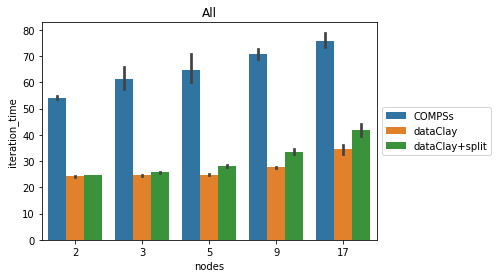

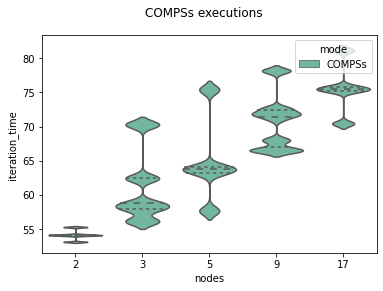

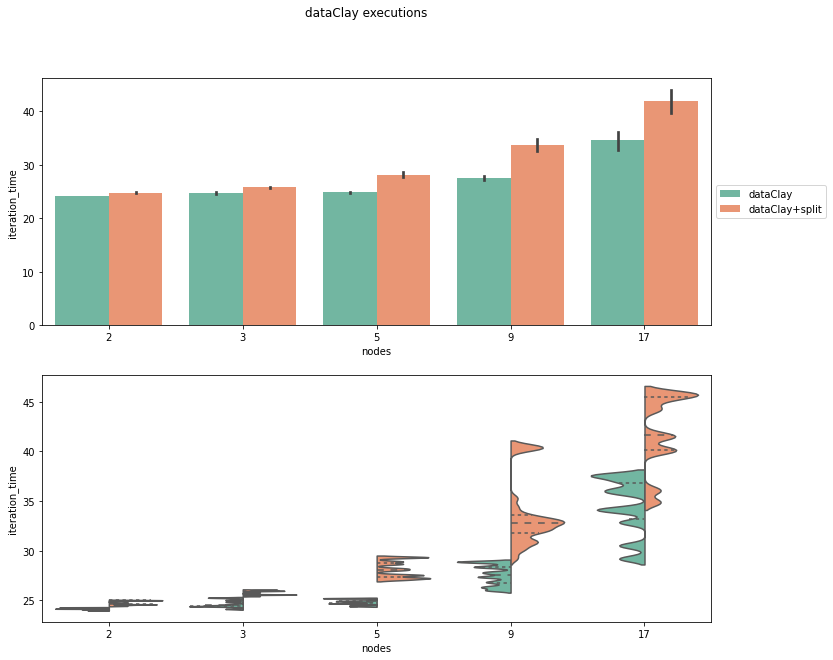

initialization_time  iteration_time
nodes mode                                               
2     COMPSs                    16.888948       54.141289
      dataClay                  69.635622       24.156209
      dataClay+split            70.360633       24.732879
3     COMPSs                    17.537581       61.107669
      dataClay                  83.182684       24.649392
      dataClay+split            83.664813       25.764011
5     COMPSs                    18.350647       64.827541
      dataClay                 140.139650       24.809918
      dataClay+split           140.804705       28.097775
9     COMPSs                    20.646929       70.722126
      dataClay                 261.204072       27.553654
      dataClay+split           262.948461       33.563588
17    COMPSs                    19.897897       75.620409
      dataClay                 507.322544       34.502812
      dataClay+split           507.590789       41.923114

In [5]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("((number_of_fragments / (nodes - 1)) == 48) and ((points_per_fragment) == (64000 * 48))")
big_blocks_data = data.copy()
big_blocks_data["nodes"] -= 1

plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Blocksize sweep

8 worker nodes, analyze multiple block sizes (from 128000 points per block to 48 blocks per node). Those are the scenarios of weak scaling (see previous experiments).

In [6]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("(nodes == 9) and ((number_of_fragments * points_per_fragment) == 1179648000)")

def eval_granularity_index(row):
    row["granularity_index"] = row["number_of_fragments"] // (48 * 8)
    return row

data = data.apply(eval_granularity_index, axis=1)
sweep_data = data.copy()

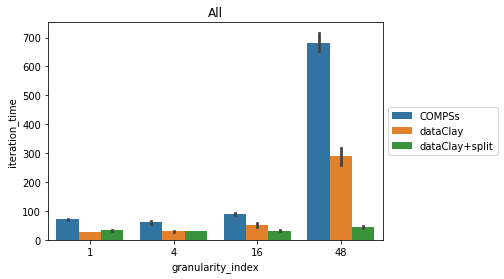

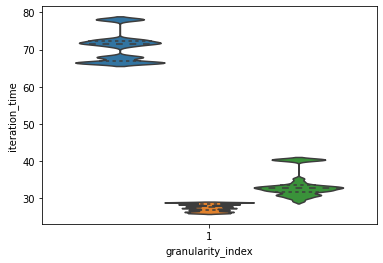

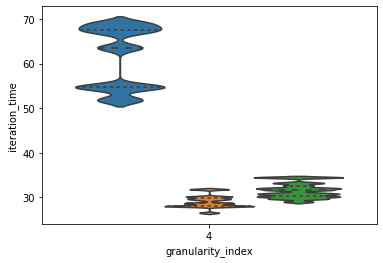

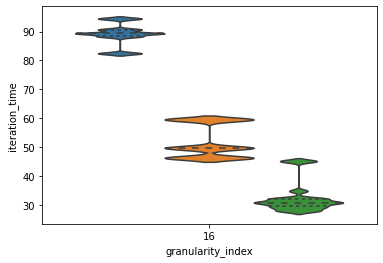

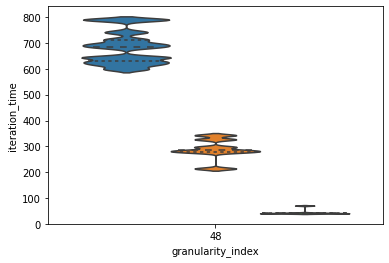

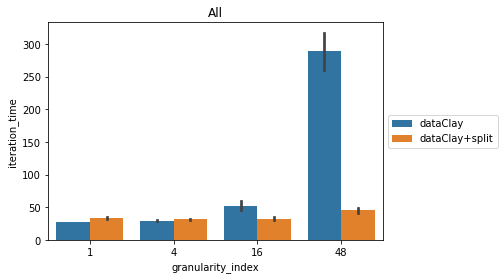

initialization_time  iteration_time
granularity_index mode                                               
1                 COMPSs                    20.646929       70.722126
                  dataClay                 261.204072       27.553654
                  dataClay+split           262.948461       33.563588
4                 COMPSs                    18.951145       61.360624
                  dataClay                 258.181876       29.094301
                  dataClay+split           261.353496       31.611503
16                COMPSs                    18.756459       89.102875
                  dataClay                 258.061558       51.863610
                  dataClay+split           260.351928       32.305725
48                COMPSs                    25.151372      682.015304
                  dataClay                 322.611034      289.372595
                  dataClay+split           265.290424       45.042413

In [7]:
sns.barplot(data=data, x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
# TODO: Change granularity_index to: fragments per core [o algo així]
plt.show()

for i in [1, 4, 16, 48]:
    ax = sns.violinplot(data=data.query("granularity_index == %d" % i),
                        x="granularity_index", hue="mode", y="iteration_time", 
                        scale='width', bw=VIOLIN_BW,
                        inner="quartile", figsize=123)
    ax.get_legend().remove()
    plt.show()

sns.barplot(data=data.query("dataclay == 1"), x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
plt.show()

data = data.drop(data.columns.difference(["granularity_index", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["granularity_index", "mode"]).mean()


# Figure generation

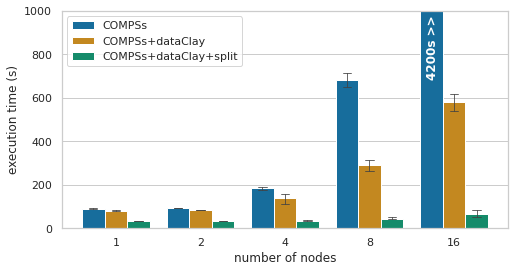

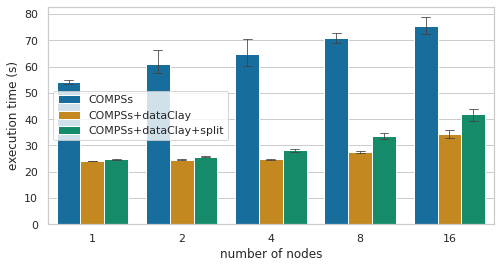

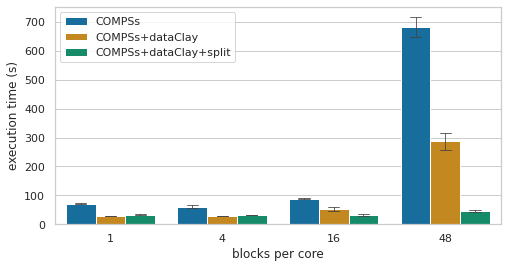

In [8]:
sns.set(style="whitegrid", color_codes=True)

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

# Special case: let's force the y_lim and let's write the value inside the bar
ax.set_ylim([0, 1000])
ax.text(3.75, 980, "4200s >>", ha="center", va="top", rotation=90, color="white", weight="semibold")
for idx, rect in enumerate(ax.plot()):
    print(idx)

save_tweaks("kmeans-weakscaling_smallblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("kmeans-weakscaling_bigblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="granularity_index", hue="mode",
                 data=sweep_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("blocks per core")

save_tweaks("kmeans-blocksweep.pdf")
plt.show()


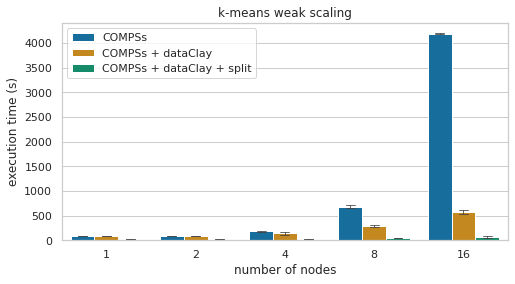

In [9]:
ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs + dataClay", "COMPSs + dataClay + split"])
ax.set_title("k-means weak scaling")
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("kmeans-anotherpresentation.png")
plt.show()
